In [1]:
dataset = '/home/ubuntu/文档/Synthetic Chinese String Dataset/'
# tf's CTC: the last class is reserved to the blank label.
char = ''
with open(dataset + 'char_std_5990.txt', encoding='utf-8') as f:
    for ch in f.readlines():
        ch = ch.strip('\r\n')
        char = char + ch
            
# 使用 卍 代替 blank 来可视化输出
char =char[:len(char)-5]+'卍'
nclass = len(char)
print('nclass:', nclass)
id_to_char = {i:j for i,j in enumerate(char)}

nclass: 5990


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import keras.backend as K
from keras.models import Model
from keras.layers import Input
from keras.utils import multi_gpu_model
import tensorflow as tf

from imp import reload 
import densenet
reload(densenet) # 自动检测修改源码 reload


gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True))
K.set_session(session)


modelPath = './model/densenet-model.h5'
input = Input(shape=(32, None, 1), name='the_input')
y_pred = densenet.dense_cnn(input, nclass)
model = Model(inputs=input, outputs=y_pred)
model.load_weights(modelPath)


def resize(img):
    scale = img.size[1] * 1.0 / 32
    w = int(img.size[0] / scale)
    img = img.resize((w, 32), Image.ANTIALIAS)
    return img

def predict(img):
    img = img.convert('L')
    img = resize(img)
    
    img = np.array(img).astype(np.float32) / 255.0 - 0.5
    X = np.expand_dims(img, axis=2)
    X = np.array([X])
    
    y_pred = model.predict(X)
    y_pred = y_pred[:,:,:]
    out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1])[0][0])[:, :]
    out = ''.join([id_to_char[x] for x in out[0]])
    return out

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ctc_decode(y_pred, input_length, greedy=True, beam_width=None, dict_seq_lens=None, dict_values=None)

使用贪婪算法或带约束的字典搜索算法解码softmax的输出

参数：

y_pred：形如(samples，time_steps，num_categories)的张量，包含预测值或输出的softmax值

input_length：形如(samples，1)的张量，包含y_pred中每个batch的序列长

greedy：设置为True使用贪婪算法，速度快

dict_seq_lens：dic_values列表中各元素的长度

dict_values：列表的列表，代表字典

返回值：形如(samples，time_steps，num_catgories)的张量，包含了路径可能性（以softmax概率的形式）。注意仍然需要一个用来取出argmax和处理空白标签的函数

预测结果 0x38e3fEc4C的61E72c9452078Ea7AFe8D4217B0D57


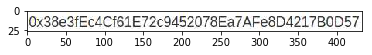

In [3]:
testimage = 'img/demo.jpg'
img = Image.open(testimage)
out = predict(img)
print('预测结果', out)
plt.imshow(img)